In [254]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score , roc_auc_score , roc_curve
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

import platform
if platform.system() == 'Window' :
    plt.rc('font', famiily = 'NanumGothic' )

In [97]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_1_obesity_v2.csv',encoding= 'cp949')
df = df.drop(['Unnamed: 0', 'id'] , axis = 1)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,male,27,1.80,87,no,no,always,3,sometimes,no,between 1 and 2 l,no,2 to 4,0 to 2,frequently,walking,overweight_level_i,26.851852
1,male,26,1.85,105,yes,yes,always,3,frequently,no,more than 2 l,no,2 to 4,>5,sometimes,public_transportation,obesity_type_i,30.679328
2,male,41,1.80,99,no,yes,sometimes,3,sometimes,no,between 1 and 2 l,no,2 to 4,3 to 5,frequently,automobile,obesity_type_i,30.555556
3,female,29,1.53,78,no,yes,sometimes,1,sometimes,no,between 1 and 2 l,no,0,0 to 2,no,automobile,obesity_type_i,33.320518
4,female,23,1.65,70,yes,no,sometimes,1,sometimes,no,between 1 and 2 l,no,0,0 to 2,sometimes,public_transportation,overweight_level_i,25.711662


### 1-1 EDA & 결측치 및 이상치를 판단하고 설명

In [98]:
df = df.dropna()

<Axes: >

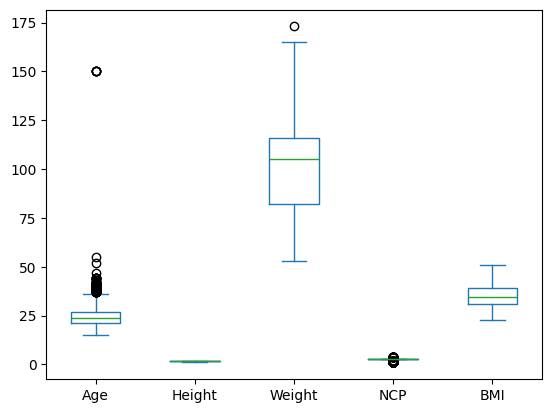

In [99]:
## 이상치 판단 - box plot 
num_cols = df.select_dtypes(exclude ='object').columns
df[num_cols].plot(kind = 'box')     

<Axes: >

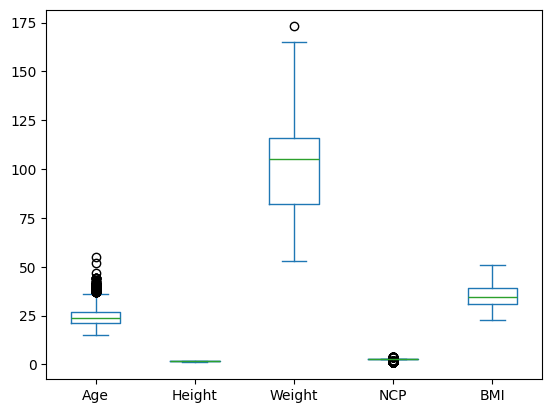

In [100]:
## 이상치 삭제 
df1 = df.copy()
df1 = df1[df1['Age'] < 100]
df1[num_cols].plot(kind = 'box')     

In [101]:
# 피처 엔지니어링

# 라벨 인코딩 (계산을 위해서)
for col in df1.columns : 
    if df1[col].dtypes == 'object' :
        le  = LabelEncoder()
        df1[col] = le.fit_transform(df1[col])

# 1) 식사횟수 * (고칼로리 + 알콜 섭취)
df1['NCP_FAVC_CALC'] = df1['NCP'] * (df1['FAVC'] + df1['CALC'])

# 2) FAF * TUE: This could show the potential impact of physical activity in relation to screen time.
df1['FAF_TUE'] = df1['FAF'] * df1['TUE']

앙상블을 제외한 분류 모델 3가지 구축 및 결과 비교 및 설명b

In [165]:


x = df1.drop('NObeyesdad', axis = 1)
y = df1['NObeyesdad']

# X_scaling 
ss = StandardScaler()
s_x = pd.DataFrame(ss.fit_transform(x) , columns = x.columns)

x_train, x_test, y_train, y_test = train_test_split(s_x, y, test_size = 0.3 , random_state= 1243) 

lr = LogisticRegression()
dt = DecisionTreeClassifier()
svc = SVC()

lst = {}
model_lst = []

def modelling (model, name) :
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = f1_score(y_test, y_pred , average = 'weighted')
    return {name : acc} , model 

for name ,models in (['Linear', lr], ['Decisiton_Tree', dt] , ['SCV', svc]) : 
    acc, model = modelling(model, name)
    lst.update(acc)
    model_lst.append(model)

pd.DataFrame(lst.items())

,0,1
0,Linear,0.941064
1,Decisiton_Tree,0.941064
2,SCV,0.941064


In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score

param_grid = {
    'criterion' : ['gini', 'entropy'] , 
    'max_depth' : [3, 5, 10] ,
    'min_samples_split' : [2,5,10]    
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5)
grid_search.fit(x_train, y_train)

# 최적의 모델 
best_model= grid_search.best_estimator_
y_pred = best_model.predict(x_test)

precision= precision_score(y_test, y_pred, average ='weighted')
recall = recall_score(y_test, y_pred, average ='weighted')

# 성능 출력 
print("Best Paramaters : ", grid_search.best_params_)
print("Precision :" , precision)
print("Recall :" , recall)

## 자세한 성능 평가 
print(classification_report(y_test, y_pred))

Best Paramaters :  {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}
Precision : 0.9795488579260813
Recall : 0.9787798408488063
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       108
           1       0.95      0.99      0.97        99
           2       0.97      1.00      0.98        91
           3       1.00      1.00      1.00        79

    accuracy                           0.98       377
   macro avg       0.98      0.98      0.98       377
weighted avg       0.98      0.98      0.98       377



2-1의 3가지 모델을 soft voting을 이용하여 모델링 한 결과와 2-2과 비교

In [164]:
from sklearn.ensemble import VotingClassifier

lr = LogisticRegression()
dt = DecisionTreeClassifier()
svc = SVC(probability = True)

soft_voting = VotingClassifier(estimators = [('lr', lr) , ('dt', dt), ('svc', svc)] , voting = 'soft')
soft_voting.fit(x_train, y_train)

soft_pred = soft_voting.predict(x_test)
soft_precision= precision_score(y_test, soft_pred, average ='weighted')
soft_recall = recall_score(y_test, soft_pred, average ='weighted')

print(soft_precision , soft_recall)

0.9893939622568299 0.9893899204244032


 하나의 모델을 선정하여 Drop Column Importance 방식으로 각 변수 별로 전체 컬럼을 포함한 모델과의 recall 값의 차이를 계산하고 시각화

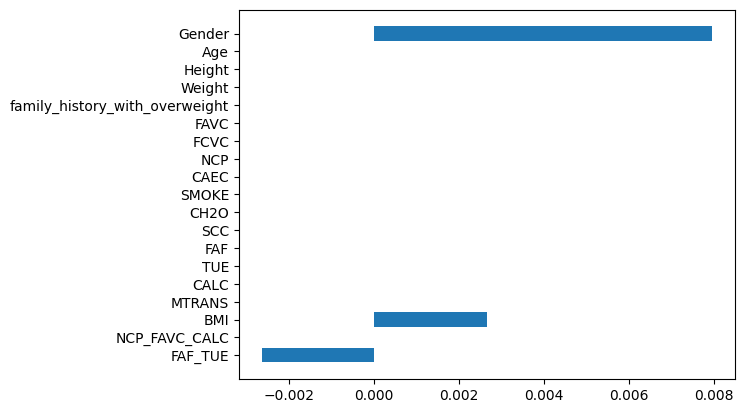

In [174]:
dt = DecisionTreeClassifier(random_state = 24)
dt.fit(x_train, y_train)
y_pred_full = dt.predict(x_test)
recall_full = recall_score(y_test, y_pred_full , average= 'weighted')


## Drop Columns Importance 방식으로 변수별 Recall 차이 
lst = []

for col in x.columns:
    # 해당 변수를 제거한 데이터셋 준비
    x_train_drop = x_train.drop(columns=[col])
    x_test_drop = x_test.drop(columns=[col])
    
    # 모델 학습
    dt.fit(x_train_drop, y_train)
    y_pred_drop = dt.predict(x_test_drop)
    
    # Recall 계산
    recall_drop = recall_score(y_test, y_pred_drop, average='weighted')

    # 차이 계산 
    recall_diff = recall_full - recall_drop 
    lst.append([col, recall_diff])

recall_df = pd.DataFrame(lst, columns = ['Feature','Recall_diff'])

plt.barh(recall_df['Feature'], recall_df['Recall_diff'])
plt.gca().invert_yaxis()

4-1 아래의 기준으로 전처리를 하여 적정 체중 여부 컬럼을 생성하고 BMI를 5단위로 구분하여 와 적정 체중여부에 대한 빈도 표를 만들어라
bmi 계산

- Bmi = 몸무게(kg)/(키(m)**2)   

만나이 구하기

- 건강검진을 받았던 날을 기준으로 생년월일과 일수 차이가 16년 364일 이하인 경우 만 16세 그 이상의 경우 만 17로 분류하라
- 윤년 등은 고려하지 않는다. 햇수로 16년 + 일수로 364일이 기준이다


적정 체중 여부 (BMI가 아래 구간에 들어올 경우)
17세 남자 : 21.03이상 23.21 미만
17세 여자 : 20.03이상 22.39 미만
16세 남자 : 21.18이상 23.45 미만
16세 여자 : 19.61이상 21.74 미만

In [191]:
from datetime import datetime 

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_2_v2.csv')

# 1) BMI 
df['BMI'] = df['weight'] / (df['키'] / 100) ** 2

# 2) 만나이 
df['생년월일'] = pd.to_datetime(df['생년월일'], format = '%Y%m%d')
df['건강검진일']= pd.to_datetime(df['건강검진일'], format = '%Y_%m_%d')

In [196]:
df['diff'] = (df['건강검진일'] - df['생년월일'] ).dt.days 
df['만나이'] = df['diff'].map(lambda x : 16 if x <= 364 + 16 * 365 else 17)

In [219]:
def normal_weight(age, sex, bmi) : 
    if age == 16 : 
        if sex == '남자' :
            return 21.03 <= bmi < 23.21 
        else : 
            return 19.61 <= bmi <  21.74 

    else : 
        if sex == '남자' : 
            return  21.03 <= bmi < 23.21 
        else : 
            return 20.03 <= bmi < 22.39

df['적정체중여부'] = df.apply(lambda x : normal_weight(x['만나이'] , x['성별'] , x['BMI']), axis = 1)

# BMI 5단계 
df['BMI_5'] = pd.cut(df['BMI'], bins= 5 )

# margins = True : 합계를 보여줌 
pd.crosstab(df['BMI_5'] , df['적정체중여부'] , margins = True)

적정체중여부,False,True,All
BMI_5,,,
"(16.08, 18.776]",325,0,325
"(18.776, 21.459]",638,2425,3063
"(21.459, 24.141]",1869,1077,2946
"(24.141, 26.823]",451,0,451
"(26.823, 29.506]",16,0,16
All,3299,3502,6801


적정 체중 여부와 나머지 컬럼(공학여부, 아침식사여부, 일주일운동시간, 채소섭취정도, 수면시간, 성별) 이 독립적인지 통계적으로 확인

In [241]:
from scipy.stats import chi2_contingency, ttest_ind

df1 = df.drop(columns  = ['ID' , 'diff'] , axis = 1)

df1['적정체중여부']= df1['적정체중여부'].astype(int)

test_col = ['공학여부', '아침식사여부', '일주일운동시간', '채소섭취정도', '수면시간', '성별' , '적정체중여부']
test_df = df1[test_col]

lst = []
for col in test_df.columns : 
    if col in ['공학여부','아침식사여부' ,'채소섭취정도', '성별'] : 
        target = test_df[[col, '적정체중여부']]
        cross = pd.crosstab(target[col], target['적정체중여부'])
        chi2, p_val, dof, expected = chi2_contingency(cross)
        lst.append([col, p_val]) 

    else : 
        stat, p_val = stats.ttest_ind(test_df.query('적정체중여부 == 0')[col]  , \
                                      test_df.query('적정체중여부 == 1')[col] )

        lst.append([col, p_val])
        
stat_table = pd.DataFrame(lst , columns = ['Variable', 'P_value'] )
print(stat_table[stat_table['P_value'] < 0.05])

  Variable       P_value
3   채소섭취정도  3.848957e-02
4     수면시간  6.927360e-03
5       성별  1.789291e-41
6   적정체중여부  0.000000e+00


유의한 변수들만 가지고 적정 체중 여부를 예측하는 모델을 구현하고 성능 평가 및 해석을 하라 (로지스틱회귀 ,xgb)

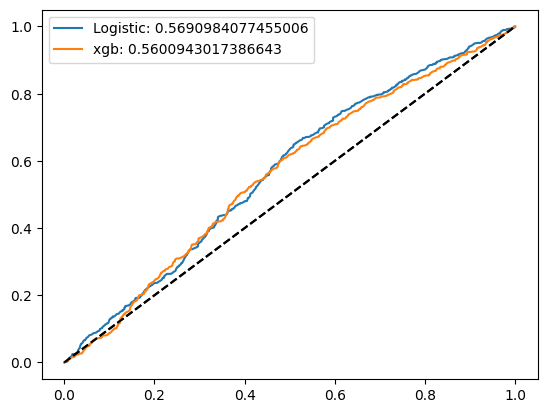

In [258]:
valid_col = ['채소섭취정도', '수면시간', '성별' ,'적정체중여부']

final_df = df1[valid_col]

# 라벨 인코딩 
for col in final_df.columns : 
    if final_df[col].dtype == 'object' :
        le = LabelEncoder()
        final_df[col] = le.fit_transform(final_df[col])


x = final_df.drop('적정체중여부', axis = 1)
y = final_df['적정체중여부']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3 , random_state= 1243) 

# Model 성행 
models = {
    'Logistic' : LogisticRegression() , 
    'xgb' : XGBClassifier()
}

for name, model in models.items() : 
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    accu = accuracy_score(y_test , pred)
    roc_score = roc_auc_score(y_test, pred)

    # ROC Curve를 위한 proba 
    proba = model.predict_proba(x_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label = f'{name}: {roc_score}')
    plt.legend()
    plt.plot([0,1],[0,1], 'k--')

 평균이 θ 이고 분산이 100인 정규분포의 사전분포가 100, 256일때 120의 값을 가지는 데이터가 있을 경우 사후평균은?

In [259]:

prior_x = 100 # 사전 분포 
prior_var = 256 

# 관측된 데이터 
x = 120 # 관측된 데이터 값 
sigma = 100 #데이터의 분산

# 사전 분포 * 관측된 데이터 값 + 데이터의 분산 * 사전분포 평균 
(prior_var * x + sigma + sigma * prior_x) / (prior_var + sigma)



114.66292134831461

회귀 모델링 후 유의하지 않는변수 파악 

In [262]:
data_path = "https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_5_advertising.csv"
df = pd.read_csv(data_path)

In [267]:
import statsmodels.api as sm 

x = df.drop('Sales', axis = 1)
y = df['Sales']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     605.4
Date:                Sun, 06 Oct 2024   Prob (F-statistic):           8.13e-99
Time:                        20:35:18   Log-Likelihood:                -383.34
No. Observations:                 200   AIC:                             774.7
Df Residuals:                     196   BIC:                             787.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6251      0.308     15.041      0.0

VIF를 통한 다중공선성

In [270]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['Variable'] = x.columns 
vif['vif'] = [variance_inflation_factor(x.values , i ) for i in range(x.shape[1])]
vif

,Variable,vif
0,TV,2.486772
1,Radio,3.285462
2,Newspaper,3.055245


A,B,C,D,E 영업사원의 각 계약 성사 유무 (1:계약 , 0:미계약) 를 나타낸 데이터이다. 영업사원의 평균 계약 성사 건수는 같은지 통계 검정하라

In [274]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/31/adp_31_7.csv', encoding= 'utf-8')
df.set_index('Unnamed: 0', inplace= True)

df.head()

,A,B,C,D,E
Unnamed: 0,,,,,
contract_1,1,0,1,1,1
contract_2,0,1,0,1,0
contract_3,1,0,0,0,0
contract_4,0,1,1,1,1
contract_5,0,1,0,1,0


In [276]:
from statsmodels.stats.contingency_tables import cochrans_q 

print(cochrans_q(df))

df          4
pvalue      0.3406392758219471
statistic   4.516129032258065


유기견이 하루에 2.2마리 발생한다
1) 한 마리도 안 버려질 확률
2) 적어도 2마리 버려질 확률

In [284]:
from scipy.stats import poisson

lamb = 2.2 
print(poisson.pmf(0, lamb))

# 적어도 2마리 = 2마리 이상 1- cdf(1)
print(1 - poisson.cdf(1, lamb))

0.11080315836233387
0.6454298932405317
